In [35]:
# inner module import
import sys
sys.path.append("/storage/homefs/yc24j783/datacat4ml/datacat4ml")
from const import DATA_DIR, FIG_DIR, FETCH_DATA_DIR , FETCH_FIG_DIR

import os
from typing import List
# load ipython-sql, a Jupyter Notebook magic extension. 
%load_ext sql 
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.metrics import r2_score,cohen_kappa_score,balanced_accuracy_score,\
    median_absolute_error,matthews_corrcoef
import hashlib
from collections import Counter

from rdkit import Chem
from rdkit.Chem import AllChem

#-------------------------------------------------------------------------------------------------
# categorical TMAP based on three categories of SMILES
#-------------------------------------------------------------------------------------------------
import tmap as tm
from faerun import Faerun
#from mapchiral.mapchiral import encode_many
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdmolops
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
import json
import random
from mhfp.encoder import MHFPEncoder
from mhfp.lsh_forest import LSHForestHelper

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


# Connect to the database

In [2]:
%sql sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db

'Connected: @/storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db'

# Fetch GPCR data

## uniport_ids

In [3]:
# All GPCR proteins in human
GPCR_human = pd.read_csv(os.path.join(DATA_DIR, 'GPCR_human.tsv'),sep='\t')
gpcr_uniprot_ids_list = GPCR_human['Entry'].tolist()
print(f'The number of proteins in GPCR_human is {len(gpcr_uniprot_ids_list)}')
print(f'The first 5 proteins in GPCR_human are {gpcr_uniprot_ids_list[:5]}')

The number of proteins in GPCR_human is 898
The first 5 proteins in GPCR_human are ['Q16570', 'O00590', 'P25106', 'Q9NPB9', 'P18509']


In [4]:
# Opioid receptor proteins in human
mor_uniprot_id = 'P35372'
kor_uniprot_id = 'P41145'
dor_uniprot_id = 'P41143'
nor_uniprot_id = 'P41146'

## write the below columns to a csv file

x
- 'canonical_smiles'
- assays.
    - assay_id,
    - chembl_id --> 'assay_chembl_id',
    - doc_id, 
    
    in the maxMatch:
    - **assay_type**, e.g. B, F.
    - **assay_category**, (very sparse), e.g. Selectivity assay, Affinity biochemical assay, Affinity on-target cellular assay, Affinity phenotypic cellular assay, GPCR beta-arrestin assay, Thermal shift assay.
    - **assay_organism**, e.g. Homo sapiens, Rattus norvegicus
    - **assay_tax_id**, e.g. 9606 (for human), 1280 (for Staphylococcus aureus)
    - **assay_strain**, (median sparse), e.g. LV9, BaL.
    - **assay_tissue**, (median sparse), e.g. Brain, Plasma
    - **assay_cell_type**, (median sparse), e.g. PC-3M, CHO
    - **assay_subcellular_fraction**, (very sparse), e.g. Membrane, Microsome, Mitochondria
    - **bao_format**, (e.g, BAO_0000019: could be cell-based format, organism-based format)
    - **variant_id**, (very sparse)

    something else
    - **assay_test_type**, (sparse), e.g. in vitro, in vivo.
    - **description**
    - cell_id, (median sparse)
    - tissue_id, (median sparse)
    - curated_by, e.g. Autocuration, Intermediate, Expert. 
    - relationship_type, ? e.g. H, U, N, D, M, S 
    - aidx,  ? e.g. CLD0, 1480429, 1480486

support
- target_dictionary.chembl_id --> 'target_chembl_id'
- standard_type, standard_relation, standard_units
'compound_chembl_id'
- assays.relationship_type (e.g. D, stands for direct protein target assigned)

annotation
- asaays.src_id (e.g. integers that are unique identifiers for sources in UniChem )


y
- 'pchembl_value'

## functions

### def gather_data_for_size

In [5]:
def gather_data_for_size(uniprot_id: List[str], standard_type:str,
                         onlyDocs=True,removeMutants=True,confidenceScore=8,
                         maxAssaySize=100):
    """ Get the data for the size of the dataset """
    
    if isinstance(uniprot_id, str):
        uniprot_id = [uniprot_id]
    uniprot_id_str = ",".join(f"'{id}'" for id in uniprot_id)

    print('table temp_targets')
    %sql \
        drop table if exists temp_targets
    %sql \
        create table temp_targets as \
        select tid, component_id, accession, target_type, pref_name target_pref_name, chembl_id target_chembl_id \
        from target_components \
        join component_sequences using(component_id) \
        join target_dictionary using(tid) \
        where accession in ({uniprot_id_str}) \
        and target_type = 'SINGLE PROTEIN';

    # collect activities for the assays that meet the basic criteria
    print('table temp_assays')
    %sql \
        drop table if exists temp_assays
    %sql \
        create table temp_assays as \
        select assay_id, assays.chembl_id assay_chembl_id, assays.description assay_desc, assays.doc_id assay_doc_id, variant_id, \
        docs.year doc_date, docs.chembl_id doc_chembl_id, \
        tid, accession, target_type, target_pref_name, target_chembl_id, \
        count(distinct(molregno)) cnt \
        from activities \
        join assays using(assay_id) \
        join docs on (assays.doc_id = docs.doc_id) \
        join temp_targets using (tid) \
        where standard_type =:standard_type \
        and pchembl_value is not null \
        group by tid, assay_doc_id, assay_id \
        order by cnt desc;

    # now remove rows for assays which are not compatible without curation steps
    print('check onlyDocs')
    if onlyDocs:
        %sql \
            delete from temp_assays where doc_date is null;

    print('check removeMutants')
    if removeMutants:
        %sql \
            delete from temp_assays where variant_id is not null or lower(assay_desc) like '%mutant%'\
                or lower(assay_desc) like '%mutantion%' or lower(assay_desc) like '%variant%';
                
    print('check confidenceScore')
    # filter out assays with confidence score less than confidenceScore
    %sql \
        drop table if exists temp_assays_1_cs;
    %sql \
        create table temp_assays_1_cs as \
        select ta.*, confidence_score from temp_assays ta \
            join assays using(assay_id) \
            where confidence_score >= :confidenceScore;  

    # select activities from the assays we've identified which have between less than maxAssaySize tested compounds
    print('temp_acts')
    %sql \
        drop table if exists temp_acts
    %sql \
        create table temp_acts as \
        select assay_id, assay_chembl_id, tid, target_chembl_id,molregno,pchembl_value,doc_chembl_id,standard_type,activity_id \
        from activities \
        join temp_assays_1_cs using (assay_id)\
        where pchembl_value is not null \
        and standard_type =:standard_type \
        and cnt <= :maxAssaySize;  

    # count the number of unique compounds in each assay id
    print('temp_acts_counts')
    %sql \
        drop table if exists temp_acts_counts
    %sql \
        create table temp_acts_counts as \
        select assay_id, assay_chembl_id, ta.tid, target_chembl_id, count(distinct molregno) cnt, doc_chembl_id \
        from temp_acts ta \
        join assays using (assay_id) \
        group by assay_chembl_id, target_chembl_id, doc_chembl_id \
        order by cnt desc;
    
    # count the number of unique compounds in each assay id
    print('temp_targets_counts')
    %sql \
        drop table if exists temp_targets_counts
    %sql \
        create table temp_targets_counts as \
        select tid, target_chembl_id, count(distinct assay_chembl_id) target_assay_count, sum(cnt) target_compound_count \
        from temp_acts_counts tac \
        group by target_chembl_id \
        order by target_assay_count desc;
        

#### temp_targets

In [ ]:
uniprot_id = gpcr_uniprot_ids_list
if isinstance(uniprot_id, str):
    uniprot_id = [uniprot_id]
uniprot_id_str = ",".join(f"'{id}'" for id in uniprot_id)

print('table temp_targets')
%sql \
    drop table if exists temp_targets
%sql \
    create table temp_targets as \
    select tid, component_id, accession, target_type, pref_name target_pref_name, chembl_id target_chembl_id \
    from target_components \
    join component_sequences using(component_id) \
    join target_dictionary using(tid) \
    where accession in ({uniprot_id_str}) \
    and target_type = 'SINGLE PROTEIN';

# display the table
target_df = %sql select * from temp_targets;
print(f'The shape of the target_df is {target_df.DataFrame().shape}')
target_df

#### temp_assays

In [ ]:
standard_type = 'IC50'
print('table temp_assays')
# collect activities for the assays that meet the basic criteria
%sql \
    drop table if exists temp_assays
%sql \
    create table temp_assays as \
    select assay_id, assays.chembl_id assay_chembl_id, assays.description assay_desc, assays.doc_id assay_doc_id, variant_id, \
    docs.year doc_date, docs.chembl_id doc_chembl_id, \
    tid, accession, target_type, target_pref_name, target_chembl_id, \
    count(distinct(molregno)) cnt \
    from activities \
    join assays using(assay_id) \
    join docs on (assays.doc_id = docs.doc_id) \
    join temp_targets using (tid) \
    where standard_type =:standard_type \
    and pchembl_value is not null \
    group by tid, assay_doc_id, assay_id \
    order by cnt desc;

# save temp_assays to a pandas dataframe
assay_df_pre = %sql select * from temp_assays
assay_df = assay_df_pre.DataFrame()
print(f'The shape of the assay_df is {assay_df.shape}')
assay_df.head(1)

#### temp_assays_1_cs

In [ ]:
onlyDocs = True
removeMutants = True
confidenceScore = 8    

# now remove rows for assays which are not compatible without curation steps
print('check onlyDocs')
if onlyDocs:
    %sql \
        delete from temp_assays where doc_date is null;
print('check removeMutants')
if removeMutants:
    %sql \
        delete from temp_assays where variant_id is not null or lower(assay_desc) like '%mutant%'\
            or lower(assay_desc) like '%mutantion%' or lower(assay_desc) like '%variant%';
print('check confidenceScore')
# filter out assays with confidence score less than confidenceScore
%sql \
    drop table if exists temp_assays_1_cs;
%sql \
    create table temp_assays_1_cs as \
    select ta.*, confidence_score from temp_assays ta \
        join assays using(assay_id) \
        where confidence_score >= :confidenceScore;

# save temp_assays to a pandas dataframe
curated_assay_df_pre = %sql select * from temp_assays_1_cs
curated_assay_df = curated_assay_df_pre.DataFrame()
print(f'The shape of the assay_df is {curated_assay_df.shape}')
# display the rows 50-100 of the table
curated_assay_df.sort_values(by='cnt', ascending=True).iloc[:5]

In [ ]:
# display the rows where confidence_score is 8 and target_chembl_id is 'CHEMBL233'
curated_assay_df_8 = curated_assay_df[curated_assay_df['confidence_score'] == 8]
print(f'The shape of the curated_assay_df_8 is {curated_assay_df_8.shape}')

#### temp_acts

In [ ]:
maxAssaySize = 100
# select activities from the assays we've identified which have between less than maxAssaySize tested compounds
print('temp_acts')
%sql \
    drop table if exists temp_acts
%sql \
    create table temp_acts as \
    select assay_id, assay_chembl_id, tid, target_chembl_id,molregno,pchembl_value,doc_chembl_id,standard_type,activity_id \
    from activities \
    join temp_assays_1_cs using (assay_id)\
    where pchembl_value is not null \
    and standard_type =:standard_type \
    and cnt <= :maxAssaySize;

# save temp_assays to a pandas dataframe
temp_acts_df_pre = %sql select * from temp_acts
temp_acts_df = temp_acts_df_pre.DataFrame()
print(f'The shape of the temp_acts_df is {temp_acts_df.shape}')
temp_acts_df.head(1)

#### temp_acts_counts

In [ ]:
# count the number of unique compounds in each assay id
print('temp_acts_counts')
%sql \
    drop table if exists temp_acts_counts
%sql \
    create table temp_acts_counts as \
    select assay_id, assay_chembl_id, ta.tid, target_chembl_id, count(distinct molregno) cnt, doc_chembl_id \
    from temp_acts ta \
    join assays using (assay_id) \
    group by assay_chembl_id, target_chembl_id, doc_chembl_id \
    order by cnt desc;

# save temp_assays to a pandas dataframe
temp_acts_counts_df_pre = %sql select * from temp_acts_counts
temp_acts_counts_df = temp_acts_counts_df_pre.DataFrame()
print(f'The shape of the temp_acts_counts_df is {temp_acts_counts_df.shape}')
temp_acts_counts_df

In [ ]:
# check the duplicate combinations of 'target_chembl_id and doc_chembl_id'
# here we discuss the necessity to only get one assay per target per doc --> not necessary
%sql \
    drop table if exists test_table
%sql \
    create table test_table as \
    select target_chembl_id, doc_chembl_id, COUNT(*) \
    from temp_acts_counts \
    group by target_chembl_id, doc_chembl_id \
    having COUNT(*) > 1;

test_table_df_pre = %sql select * from test_table
test_table_df = test_table_df_pre.DataFrame()
print(f'The shape of the test_table_df is {test_table_df.shape}')
test_table_df

#### temp_targets_counts

In [ ]:
# count the number of unique compounds in each assay id
print('temp_targets_counts')
%sql \
    drop table if exists temp_targets_counts
%sql \
    create table temp_targets_counts as \
    select tid, target_chembl_id, count(distinct assay_chembl_id) target_assay_count, sum(cnt) target_compound_count \
    from temp_acts_counts tac\
    group by target_chembl_id \
    order by target_assay_count desc;

# save temp_assays to a pandas dataframe
temp_targets_counts_df_pre = %sql select * from temp_targets_counts
temp_targets_counts_df = temp_targets_counts_df_pre.DataFrame()
print(f'The shape of the temp_targets_counts_df is {temp_targets_counts_df.shape}')
temp_targets_counts_df

In [ ]:
temp_targets_counts_df[temp_targets_counts_df['target_chembl_id'] == 'CHEMBL2014']

### Process the assay info

In [6]:
def append_assay_info(readout = 'Ki',uniprot_id = gpcr_uniprot_ids_list,
                      onlyDocs=True,removeMutants=True,confidenceScore=9):
    '''
    Append the assay information to the output of function gather_data_for_size
    '''
    
    gather_data_for_size(uniprot_id=uniprot_id,standard_type=readout,
                         onlyDocs=onlyDocs,removeMutants=removeMutants,confidenceScore=confidenceScore)

    print (f'raw_data for {readout}')
    raw_data = %sql \
    select assay_id, temp_assays.assay_chembl_id, temp_assays.tid, temp_assays.target_chembl_id, standard_type, pchembl_value, \
    assay_type,assay_category,assay_organism, assay_tax_id, assay_strain, assay_tissue, assay_cell_type, assay_subcellular_fraction, bao_format, temp_assays.variant_id, assay_test_type, \
    assay_desc, cell_id, tissue_id, curated_by, relationship_type, aidx, \
    molregno, cid.chembl_id compound_chembl_id,canonical_smiles \
    from activities \
    join temp_assays using (assay_id) \
    join temp_acts_counts using (assay_id) \
    join temp_targets_counts using (tid) \
    join assays using (assay_id) \
    join chembl_id_lookup cid on (entity_type='COMPOUND' and molregno=entity_id) \
    join compound_structures using (molregno) \
    where pchembl_value is not null   \
        and standard_type=:readout;

    return raw_data
    
def hash_assay_info(raw_data, sel_cols:List[str]=['assay_type', 'assay_organism', 'assay_category',
                                                        'assay_tax_id','assay_strain','assay_tissue',
                                                        'assay_cell_type','assay_subcellular_fraction',
                                                        'bao_format','variant_id','assay_test_type','assay_desc', 
                                                        'cell_id', 'tissue_id', 'curated_by', 'relationship_type', 'aidx']):
    '''
    For the retrieved data from the database, concatenate the columns related to assay info, hash these values, and convert the data into a pandas dataframe.

    params:
        raw_data: The retrieved data from the database.
        sel_cols: A list of column names to be used for hashing.

    Returns:
        A pandas DataFrame with the original data and an additional 'assay_info_hash' column.

    The string in the sel_cols can be the below:
    'assay_type','assay_organism','assay_category',
    'assay_tax_id','assay_strain','assay_tissue',
    'assay_cell_type','assay_subcellular_fraction','bao_format','variant_id'
    '''

    processed_data = []
    for row in raw_data:
        original_data= [str(value) for value in row]
        # concatenate certain fields and hash
        assay_fields = ''.join([str(row[col]) for col in sel_cols])  # Add all fields you need
        hash_result = hashlib.md5(assay_fields.encode()).hexdigest()
        original_data.append(hash_result)
        processed_data.append(tuple(original_data))

    print(f'The length of the processed_data is {len(processed_data)}')

    return processed_data

#### IC50

In [7]:
readout = 'IC50'
print(f'raw_data for {readout}_mincuration')
raw_data = append_assay_info(readout=readout, uniprot_id=gpcr_uniprot_ids_list,
                             onlyDocs=False,removeMutants=False,confidenceScore=8)
ic50_mincur_data = hash_assay_info(raw_data)

raw_data for IC50_mincuration
table temp_targets
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
table temp_assays
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
check onlyDocs
check removeMutants
check confidenceScore
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
temp_acts
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
temp_acts_counts
 * sqlite:////storage/homefs/yc24j783/dat

In [8]:
readout = 'IC50'
print(f'raw_data for {readout}_maxcuration')
raw_data = append_assay_info(readout=readout, uniprot_id=gpcr_uniprot_ids_list,
                             onlyDocs=True,removeMutants=True,confidenceScore=9)
ic50_maxcur_data = hash_assay_info(raw_data)

raw_data for IC50_maxcuration
table temp_targets
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
table temp_assays
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
check onlyDocs
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
124 rows affected.
check removeMutants
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
232 rows affected.
check confidenceScore
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
temp_acts
 * sqlite:////storage/homefs/yc2

#### Ki

In [9]:
readout = 'Ki'
print(f'raw_data for {readout}_mincuration')
raw_data = append_assay_info(readout=readout, uniprot_id=gpcr_uniprot_ids_list,
                             onlyDocs=False,removeMutants=False,confidenceScore=8)
ki_mincur_data = hash_assay_info(raw_data)

raw_data for Ki_mincuration
table temp_targets
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
table temp_assays
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
check onlyDocs
check removeMutants
check confidenceScore
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
temp_acts
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
temp_acts_counts
 * sqlite:////storage/homefs/yc24j783/datac

In [10]:
readout = 'Ki'
print(f'raw_data for {readout}_maxcuration')
raw_data = append_assay_info(readout=readout, uniprot_id=gpcr_uniprot_ids_list,
                             onlyDocs=True,removeMutants=True,confidenceScore=9)
ki_maxcur_data = hash_assay_info(raw_data)

raw_data for Ki_maxcuration
table temp_targets
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
table temp_assays
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
check onlyDocs
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
59 rows affected.
check removeMutants
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
181 rows affected.
check confidenceScore
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
temp_acts
 * sqlite:////storage/homefs/yc24j7

#### EC50

In [11]:
readout = 'EC50'
print(f'raw_data for {readout}_mincuration')
raw_data = append_assay_info(readout=readout, uniprot_id=gpcr_uniprot_ids_list,
                             onlyDocs=False,removeMutants=False,confidenceScore=8)
ec50_mincur_data = hash_assay_info(raw_data)

raw_data for EC50_mincuration
table temp_targets
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
table temp_assays
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
check onlyDocs
check removeMutants
check confidenceScore
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
temp_acts
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
temp_acts_counts
 * sqlite:////storage/homefs/yc24j783/dat

In [12]:
readout = 'EC50'
print(f'raw_data for {readout}_maxcuration')
raw_data = append_assay_info(readout=readout, uniprot_id=gpcr_uniprot_ids_list,
                             onlyDocs=True,removeMutants=True,confidenceScore=9)
ec50_maxcur_data = hash_assay_info(raw_data)

raw_data for EC50_maxcuration
table temp_targets
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
table temp_assays
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
check onlyDocs
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
67 rows affected.
check removeMutants
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
209 rows affected.
check confidenceScore
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
 * sqlite:////storage/homefs/yc24j783/datacat4ml/datacat4ml/Data/chembl_34_sqlite/chembl_34.db
Done.
temp_acts
 * sqlite:////storage/homefs/yc24

#### plot the datasets counts

In [13]:
def count_assay_cpd(mincur_data, maxcur_data):
    """
    calculate the number of unique assays and total compounds for each tid mincur and maxcur data
    """

    mincur_assay_count = Counter()
    mincur_cpd_count = Counter()
    maxcur_assay_count = Counter()
    maxcur_cpd_count = Counter()

    last_assay = None
    for row in mincur_data:
        tid = row[3]
        aid = row[1]
        conds = row[26]
        if aid != last_assay:
            mincur_assay_count[tid] += 1
            last_assay = aid
        mincur_cpd_count[tid] += 1

    last_assay = None
    for row in maxcur_data:
        tid = row[3]
        aid = row[1]
        conds = row[26]
        if aid != last_assay:
            maxcur_assay_count[tid+"|"+conds] += 1
            last_assay = aid
        maxcur_cpd_count[tid+"|"+conds] += 1
    
    return mincur_assay_count, mincur_cpd_count, maxcur_assay_count, maxcur_cpd_count

In [14]:
mincur_assay_count_ic50, mincur_cpd_count_ic50, maxcur_assay_count_ic50, maxcur_cpd_count_ic50 = count_assay_cpd(ic50_mincur_data, ic50_maxcur_data)
mincur_assay_count_ki, mincur_cpd_count_ki, maxcur_assay_count_ki, maxcur_cpd_count_ki = count_assay_cpd(ki_mincur_data, ki_maxcur_data)
mincur_assay_count_ec50, mincur_cpd_count_ec50, maxcur_assay_count_ec50, maxcur_cpd_count_ec50 = count_assay_cpd(ec50_mincur_data, ec50_maxcur_data)

In [19]:
def plot_dataset_size(mincur_cpd_count_ic50, maxcur_cpd_count_ic50,mincur_cpd_count_ki, maxcur_cpd_count_ki,mincur_cpd_count_ec50, maxcur_cpd_count_ec50,
                      ylabel:str='num_cpds'):
    """Plot the dataset size for mincur and maxcur data"""

    # sort the dataset by size
    mincur_scounts_ic50 = list(sorted(mincur_cpd_count_ic50.values(), reverse=True))
    maxcur_scounts_ic50 = list(sorted(maxcur_cpd_count_ic50.values(), reverse=True))
    mincur_scounts_ki = list(sorted(mincur_cpd_count_ki.values(), reverse=True))
    maxcur_scounts_ki = list(sorted(maxcur_cpd_count_ki.values(), reverse=True))
    mincur_scounts_ec50 = list(sorted(mincur_cpd_count_ec50.values(), reverse=True))
    maxcur_scounts_ec50 = list(sorted(maxcur_cpd_count_ec50.values(), reverse=True))

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)

    plt.plot(mincur_scounts_ic50,label='IC50')
    plt.plot(mincur_scounts_ki,label='Ki')
    plt.plot(mincur_scounts_ec50,label='EC50')

    plt.legend()
    plt.xlabel('data set (target) index');
    plt.ylabel(ylabel)
    plt.title('minimal curation');
    plt.ylim(0,5500)

    plt.subplot(1,2,2)
    plt.plot(maxcur_scounts_ic50,label='IC50')
    plt.plot(maxcur_scounts_ki,label='Ki')
    plt.plot(maxcur_scounts_ec50,label='EC50')

    plt.legend()
    plt.xlabel('data set (target+conditions) index');plt.xlim(-5,100)
    plt.title('maximal curation');
    plt.ylim(0,5500)
    plt.tight_layout()

    plt.savefig(f'{FETCH_FIG_DIR}/combined_{ylabel}_sizes.pdf',bbox_inches='tight')

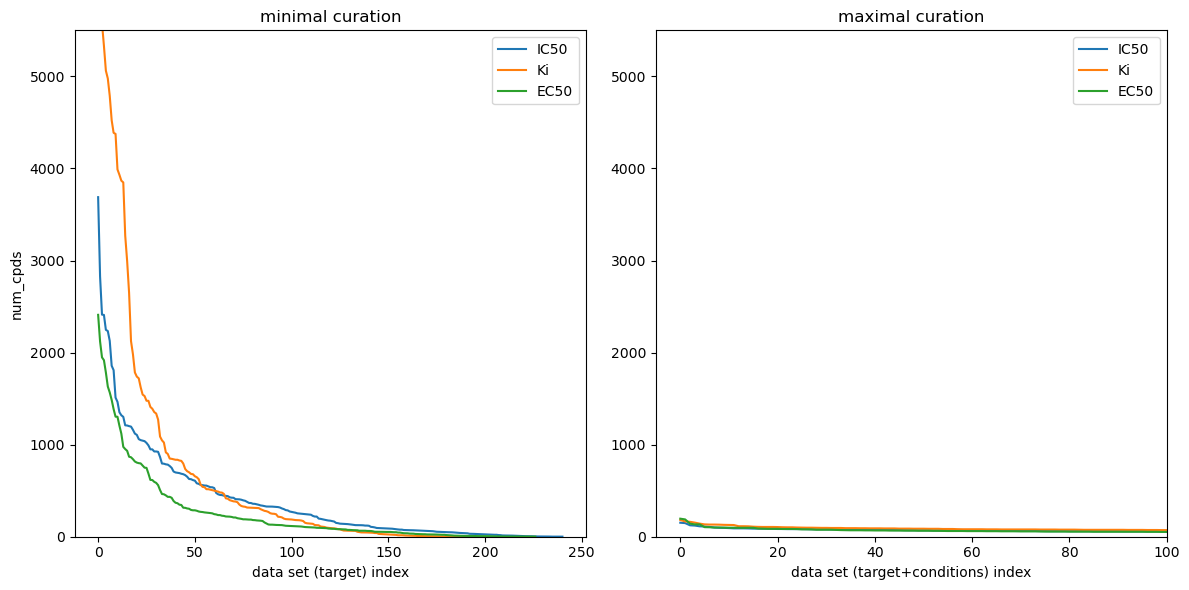

In [20]:
plot_dataset_size(mincur_cpd_count_ic50, maxcur_cpd_count_ic50,mincur_cpd_count_ki, maxcur_cpd_count_ki,mincur_cpd_count_ec50, maxcur_cpd_count_ec50,
                  ylabel='num_cpds')

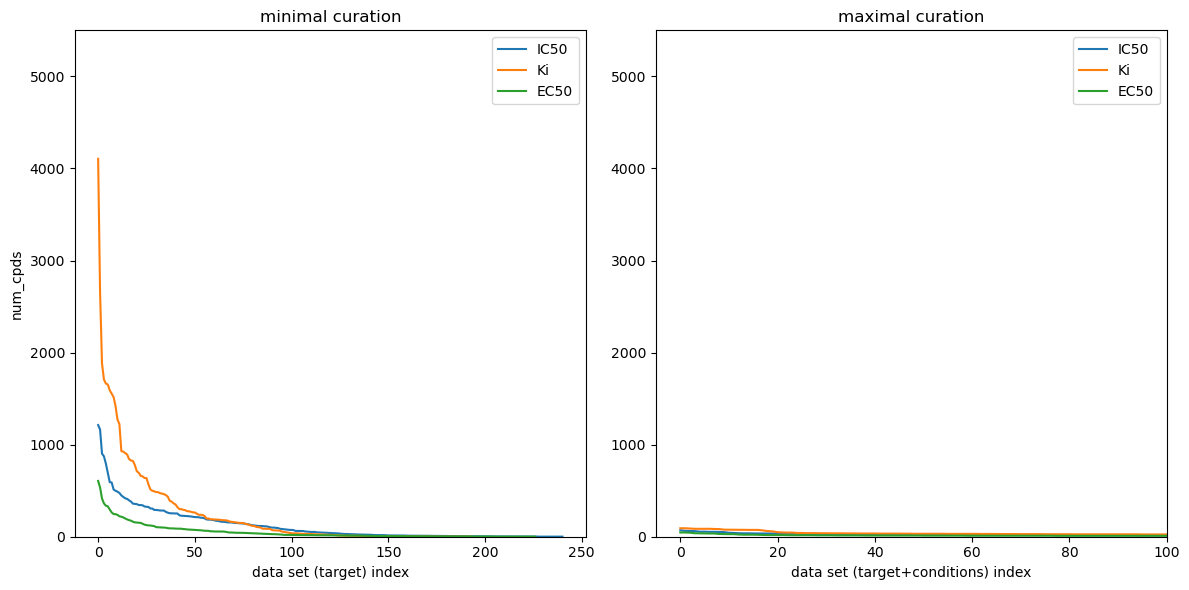

In [21]:
plot_dataset_size(mincur_assay_count_ic50, maxcur_assay_count_ic50,mincur_assay_count_ki, maxcur_assay_count_ki,mincur_assay_count_ec50, maxcur_assay_count_ec50,
                  ylabel='num_cpds')

#### write the datasets

In [29]:
def write_data(data, filename:str, columns=['assay_id', 'assay_chembl_id', 'tid', 'target_chembl_id', 'standard_type', 'pchembl_value', 
                                   'assay_type', 'assay_category', 'assay_organism', 'assay_tax_id', 'assay_strain', 'assay_tissue', 'assay_cell_type', 'assay_subcellular_fraction', 'bao_format', 'variant_id', 'assay_test_type', 
                                   'assay_desc', 'cell_id', 'tissue_id', 'curated_by', 'relationship_type', 'aidx', 
                                   'molregno', 'compound_chembl_id', 'canonical_smiles', 'assay_info_hash']):
    """Save the data to a pandas dataframe"""
    data_df = pd.DataFrame(data, columns=columns)
    
    # write the data to a csv file
    data_df.to_csv(f'{FETCH_DATA_DIR}/{filename}.csv',index=False)
    return data_df

In [37]:
ic50_mincur_df = write_data(ic50_mincur_data, 'ic50_mincur_data')
write_data(ic50_maxcur_data, 'ic50_maxcur_data')
write_data(ki_mincur_data, 'ki_mincur_data')
write_data(ki_maxcur_data, 'ki_maxcur_data')
write_data(ec50_mincur_data, 'ec50_mincur_data')
write_data(ec50_maxcur_data, 'ec50_maxcur_data')

,assay_id,assay_chembl_id,tid,target_chembl_id,standard_type,pchembl_value,assay_type,assay_category,assay_organism,assay_tax_id,...,assay_desc,cell_id,tissue_id,curated_by,relationship_type,aidx,molregno,compound_chembl_id,canonical_smiles,assay_info_hash
0,42200,CHEMBL658301,105,CHEMBL1983,EC50,8.92,F,None,Homo sapiens,9606,...,"Agonist induced [35S]GTP-gamma-S, binding in C...",449,None,Expert,D,CLD0,102087,CHEMBL292779,Fc1cccc(CCN2CCN(CCCc3c[nH]c4ccc(-n5cnnc5)cc34)...,6456b19f5ee51440bfa4f1224c3f063c
1,42200,CHEMBL658301,105,CHEMBL1983,EC50,8.8,F,None,Homo sapiens,9606,...,"Agonist induced [35S]GTP-gamma-S, binding in C...",449,None,Expert,D,CLD0,102088,CHEMBL304857,CN(Cc1ccccc1)C1CCN(CCCc2c[nH]c3ccc(-n4cnnc4)cc...,6456b19f5ee51440bfa4f1224c3f063c
2,42200,CHEMBL658301,105,CHEMBL1983,EC50,8.29,F,None,Homo sapiens,9606,...,"Agonist induced [35S]GTP-gamma-S, binding in C...",449,None,Expert,D,CLD0,103269,CHEMBL63799,Fc1cccc(CCC2(F)CCN(CCCc3c[nH]c4ccc(-n5cnnc5)cc...,6456b19f5ee51440bfa4f1224c3f063c
3,42200,CHEMBL658301,105,CHEMBL1983,EC50,8.77,F,None,Homo sapiens,9606,...,"Agonist induced [35S]GTP-gamma-S, binding in C...",449,None,Expert,D,CLD0,145223,CHEMBL88893,OC[C@H](NC1CCN(CC(F)Cc2c[nH]c3ccc(-n4cnnc4)cc2...,6456b19f5ee51440bfa4f1224c3f063c
4,42200,CHEMBL658301,105,CHEMBL1983,EC50,7.96,F,None,Homo sapiens,9606,...,"Agonist induced [35S]GTP-gamma-S, binding in C...",449,None,Expert,D,CLD0,103470,CHEMBL432332,FC(Cc1c[nH]c2ccc(-n3cnnc3)cc12)CN1CCC(Cc2ccccc...,6456b19f5ee51440bfa4f1224c3f063c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49821,2302311,CHEMBL5263167,10280,CHEMBL264,EC50,9.22,B,None,Homo sapiens,9606,...,Inverse agonist activity at recombinant human ...,None,None,Autocuration,D,1478251,2793885,CHEMBL5274183,C[C@]12CC[C@@H]3c4ccc(OCCCN5CCNC(=O)C5)cc4CC[C...,77400252b75cf44c2e8d33ff1705bda3
49822,2302311,CHEMBL5263167,10280,CHEMBL264,EC50,9.22,B,None,Homo sapiens,9606,...,Inverse agonist activity at recombinant human ...,None,None,Autocuration,D,1478251,2808591,CHEMBL5288889,C[C@]12CC[C@@H]3c4ccc(OCCCN5CCCCCC5)cc4CC[C@H]...,77400252b75cf44c2e8d33ff1705bda3
49823,2303322,CHEMBL5264178,10473,CHEMBL2107,EC50,5.19,B,None,Homo sapiens,9606,...,Antagonist activity at CXCR4 receptor in human...,None,None,Autocuration,D,1475965,6579,CHEMBL76,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,337d04f8d3fcb5a213da6413d10a2efa
49824,2305271,CHEMBL5303779,252,CHEMBL251,EC50,4.5,B,None,Homo sapiens,9606,...,Cross screening panel,None,None,Autocuration,D,GSK046_cross_screening_panel_ADORA2A,2473439,CHEMBL4636881,CC(=O)Nc1c(F)cc(C(=O)N[C@H]2CC[C@H](O)CC2)cc1O...,d93a11b6a10d6b0b7e5ad6a10f54ae73


### tmap functions

In [33]:
def calc_fp_in_df(df, radius=2, nbits=1024):
    '''
    Cacluate the fingerprint based on column 'canonical_smiles' in the dataframe and add it to the dataframe
    '''
    new_df = df.copy()
    # Calculate the fingerprint based on the canonical_smiles
    new_df['mol'] = new_df['canonical_smiles'].apply(Chem.MolFromSmiles)
    new_df['fp'] = new_df['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, radius, nbits))

    print(f'The shape of df is {new_df.shape}')
    
    return new_df 

def get_activity(x):
    ''' active is defined as pchembl_value > 7 '''
    if x > 7:
        return 'active'
    elif 5 < x <= 7:
        return 'intermediate'
    else:
        return 'inactive'

def tmap_plot(df, title:str,
              node_size:float=1/32, mmm_repeats:int=2, steps:int=5, k:int=1000,
              shader:str='smoothCircle',  point_scale:float=2.5, max_point_size:int=10):
    '''determining the layout of the TMAP, and plotting the TMAP'''
    lf = tm.LSHForest(512, 32) # a locality-sensitive hashing forest, used for approximate nearest neighbor search is initialized with parameters 512 and 32.
    ECFP4 = np.array(df['fp'])  # converting the FPs to vector units
    fps = []
    for i in ECFP4:
        vec = tm.VectorUint(i)
        fps.append(vec)
    lf.batch_add(fps)
    lf.index()
    cfg = tm.LayoutConfiguration()  # configuration parameters for TMAP layout
    cfg.node_size = node_size  # size of nodes which affects the magnitude of their repelling force.
    cfg.mmm_repeats = mmm_repeats  # number of repeats of the per-level layout algorithm
    cfg.sl_extra_scaling_steps = steps  # sets the number of repeats of the scaling
    cfg.k = k  # number of nearest neighbours used to create the k-nearest neighbour graph
    cfg.sl_scaling_type = tm.RelativeToAvgLength  # Defines the relative scale of the graph

    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

    # create a Faerun object
    category_labels, category_data = Faerun.create_categories(df['activity'])

    # TMAP for Aline's compounds based on the three categories, aromatic ring fraction, heavy atom counts and qualitative estimation drug-likeliness
    f = Faerun(
        view="front",
        coords=False,
        title="",
        clear_color="#FFFFFF"
    )

    labels = [] # the widget labels
    for i, s in enumerate(df['canonical_smiles']):
        labels.append(
            s
            + "__"
            # convert df['tid'].values to a list of strings and append it to the labels
            + str(df['tid'].values.tolist()[i])
            + "__"
            + str(df['assay_id'].tolist()[i])
            + "__"
            + str(df['assay_tax_id'].tolist()[i])
            )
    f.add_scatter(
        title,
        {
            "x": x,
            "y": y,
            "c": [category_data, # categories

                df['tid'].values.tolist(), # aromatic fraction
                df['assay_id'].values.tolist(), # heavy atom counts
                df['assay_tax_id'].values.tolist(), # qualitative estimation of drug likeliness

                ],
            "labels": labels, # SMILES as labels
        },
        point_scale=point_scale,
        max_point_size=max_point_size,
        shader=shader,
        legend_labels=[category_labels, None, None, None],
        categorical=[True, False, False, False],
        colormap=['Set1', 'rainbow', 'Set1', 'rainbow' ],
        #colormap=['Set1', 'tab20', 'turbo', 'tab10' ],
        series_title=['activity', 'tid', 'assay id', 'assay tax id'],
        has_legend=True,
    )
    f.add_tree('Tree', {"from": s, "to": t}, point_helper=title)
    f.plot(title, template='smiles')

# Tmap

In [38]:
mor_ic50_mincur_df = ic50_mincur_df[ic50_mincur_df['target_chembl_id'] == 'CHEMBL233']

In [ ]:
tmap_plot(new_df, title='tmap_gpcr_ki_nodesize50', node_size=1/50)